# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-06-03 06:26:29,478 INFO    : root         : Using LISA logging configuration:
2020-06-03 06:26:29,479 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-06-03 06:26:29,778 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-06-03 06:26:29,796 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMUFaRUYvMUFaRUZTSTZfUE9TXzE5MTAxMF8xOTEwMTBfMTkyOTAyX2NvbnRhY3QnLCBsYXlvdXQ9TGHigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing 1CAEFTC3_QOS_200304_200304_125444_note.html - 162823 lines are Ok
Parsing 1CAEFTC3_QOS_200304_200304_115451_note.html - 159510 lines are Ok
Parsing 1CAEFTC3_QOS_200304_200304_105453_note.html - 157560 lines are Ok
Parsing 1EAEFTA2_QOS_200117_200117_181416_note.html - 135054 lines are Ok
Parsing 1EAEFTA2_QOS_200117_200117_202640_note.html - 132864 lines are Ok
Parsing 1EAEFTA2_QOS_200117_200117_192028_note.html - 121365 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12932.0,NaN,NaN,NaN,351.566,NaN,11.484,NaN,NaN
3175.0,7.946,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12874.0,32.976,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1263.0,NaN,1.921,0.843,NaN,NaN,NaN,NaN,NaN
1262.0,NaN,1.145,63.965,NaN,NaN,NaN,NaN,NaN
1551.0,NaN,135.891,85.217,357.447,158.032,12.346,24.781,NaN
1585.0,NaN,8.354,1.292,NaN,NaN,NaN,NaN,NaN
1236.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,671.37
2040.0,NaN,3.321,5.578,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12931.0,32.382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2054.0,NaN,5.045,4.440,NaN,NaN,NaN,NaN,NaN
1543.0,NaN,132.803,3.377,330.598,162.873,9.647,22.106,NaN
2088.0,0.776,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1577.0,NaN,31.125,0.212,NaN,NaN,NaN,NaN,NaN
1261.0,NaN,1.254,55.702,NaN,NaN,NaN,0.319,NaN
1262.0,NaN,1.596,1.522,NaN,NaN,NaN,NaN,NaN
1232.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,630.711
3089.0,24.691,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
12898.0,NaN,NaN,NaN,367.351,NaN,9.874,NaN,NaN
2119.0,0.321,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1544.0,NaN,136.425,1.278,144.350,182.68,11.967,26.747,NaN
1578.0,NaN,32.674,34.746,NaN,NaN,NaN,NaN,NaN
1260.0,NaN,1.219,50.604,NaN,NaN,NaN,NaN,NaN
1261.0,NaN,1.164,1.339,NaN,NaN,NaN,NaN,NaN
2063.0,NaN,4.947,4.980,NaN,NaN,NaN,NaN,NaN
1233.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,508.455
12822.0,34.974,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5408.0,NaN,32.029,31.230,NaN,NaN,NaN,NaN,NaN
17218.0,NaN,NaN,NaN,277.819,NaN,10.391,NaN,NaN
5029.0,NaN,1.125,24.730,NaN,NaN,NaN,NaN,NaN
5030.0,NaN,2.827,0.974,NaN,NaN,NaN,NaN,NaN
5617.0,NaN,NaN,NaN,NaN,NaN,NaN,0.050,NaN
4970.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,549.664
5814.0,0.271,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6961.0,5.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17109.0,NaN,155.373,2.243,129.309,183.535,12.793,41.873,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5764.0,NaN,3.284,1.739,NaN,NaN,NaN,NaN,NaN
16581.0,NaN,155.983,1.966,128.352,190.346,10.894,34.494,NaN
5414.0,NaN,31.955,35.605,NaN,NaN,NaN,NaN,NaN
7015.0,14.943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16618.0,23.184,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4972.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,547.506
5037.0,NaN,1.393,20.821,NaN,NaN,NaN,NaN,NaN
5038.0,NaN,5.355,1.598,NaN,NaN,NaN,NaN,NaN
16689.0,NaN,NaN,NaN,267.956,NaN,10.042,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
5410.0,NaN,24.500,27.480,NaN,NaN,NaN,NaN,NaN
5034.0,NaN,1.626,19.826,NaN,NaN,NaN,NaN,NaN
5035.0,NaN,1.663,1.522,NaN,NaN,NaN,NaN,NaN
5741.0,NaN,2.453,1.252,NaN,NaN,NaN,NaN,NaN
16622.0,NaN,165.885,2.909,110.326,171.426,10.951,32.084,NaN
7053.0,16.208,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16658.0,26.697,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4979.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,525.731
16729.0,NaN,NaN,NaN,271.720,NaN,10.325,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

No launching time


In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                                                   pid              
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note 1236.0    671.370
                                                   1232.0    630.711
                                                   1233.0    508.455
                                                   mean      603.512
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note 4970.0    549.664
                                                   4972.0    547.506
                                                   4979.0    525.731
                                                   mean      540.967

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                                               time                                0   
                                                   RUNNING                             0   
                                                   RUNNABLE                            0   
                                                   SLEEPING                            0   
                                                   UNINTERUPTIBLE_SLEEP                0   
                                                   UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                                              Choreographer #0  \
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note time                                135.040   
                                                   RUNNING                              24.484   
                                                   RUNNABLE                              2.061   
                                                   SLEEPING                             94.128   
                                                   UNINTERUPTIBLE_SLEEP                  0.023   
                                                   UNINTERUPTIBLE_SLEEP(I/O)            14.343   
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note time                                159.080   
                                                   RUNNING                              80.632   
                                                   RUNNABLE                              0.893   
                                                   SLEEPING                             59.978   
                                                   UNINTERUPTIBLE_SLEEP                  0.212   
                                                   UNINTERUPTIBLE_SLEEP(I/O)            17.365   
DIFF                                               time                                -24.040   
                                                   RUNNING                             -56.148   
                                                   RUNNABLE                              1.168   
                                                   SLEEPING                             34.150   
                                                   UNINTERUPTIBLE_SLEEP                 -0.189   
                                                   UNINTERUPTIBLE_SLEEP(I/O)            -3.022   

                                                                              Choreographer #1  \
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note time                                 29.957   
                                                   RUNNING                              17.631   
                                                   RUNNABLE                              0.630   
                                                   SLEEPING               

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note,time,0,135.04,29.957,277.465,167.862,11.320,24.545,0
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note,time,0,159.08,2.373,122.662,181.769,11.546,36.150,0
DIFF,time,0,-24.04,27.584,154.803,-13.907,-0.226,-11.605,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note,32.976,32.382,34.974,33.444000
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note,31.045,23.184,26.697,26.975333


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [24]:
print(group1.title)
display(df1)

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_madvise+0xec/0x848,0.000000,0.000000,0.000000,0.000000,0.0,0.0
uninter_reason//SyS_mprotect+0x88/0x208,0.333333,0.000000,0.000000,0.333333,0.0,0.0
uninter_reason//__fdget_pos+0x40/0x50,0.000000,0.000000,0.333333,0.000000,0.0,0.0
uninter_reason//__percpu_down_read+0x118/0x13c,0.000000,0.000000,0.333333,0.000000,0.0,0.0
uninter_reason//__percpu_down_read+0xf0/0x108,0.000000,0.000000,0.000000,0.000000,0.0,0.0
uninter_reason//_synchronize_rcu_expedited+0x2c0/0x364,0.000000,0.000000,0.000000,0.000000,0.0,0.0
uninter_reason//binder_alloc_new_buf+0x38/0x604,0.000000,0.000000,0.000000,0.333333,0.0,0.0
uninter_reason//do_page_fault+0x2a8/0x424,0.000000,0.000000,0.000000,0.000000,0.0,0.0
uninter_reason//do_page_fault+0x2c8/0x444,0.333333,0.000000,0.000000,0.000000,0.0,0.0
uninter_reason//unlink_file_vma+0x2c/0xa8,0.000000,0.000000,0.000000,1.000000,0.0,0.0


In [25]:
print(group2.title)
display(df2)

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note


,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume
uninter_reason//SyS_madvise+0xec/0x848,0.000000,0.0,1.000000,0.000000,0.0,0.000000
uninter_reason//SyS_mprotect+0x88/0x208,0.666667,0.0,0.666667,0.000000,0.0,0.000000
uninter_reason//__fdget_pos+0x40/0x50,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//__percpu_down_read+0x118/0x13c,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//__percpu_down_read+0xf0/0x108,0.000000,0.0,1.333333,0.000000,0.0,0.000000
uninter_reason//_synchronize_rcu_expedited+0x2c0/0x364,0.000000,0.0,0.000000,0.000000,0.0,0.333333
uninter_reason//binder_alloc_new_buf+0x38/0x604,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//do_page_fault+0x2a8/0x424,6.000000,0.0,7.333333,4.333333,1.0,1.333333
uninter_reason//do_page_fault+0x2c8/0x444,0.000000,0.0,0.000000,0.000000,0.0,0.000000
uninter_reason//unlink_file_vma+0x2c/0xa8,0.000000,0.0,0.000000,0.000000,0.0,0.000000


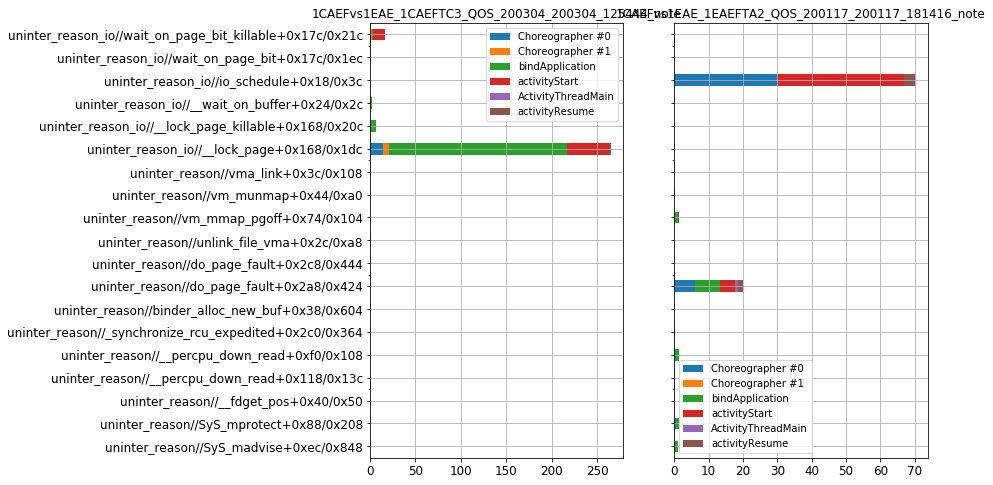

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

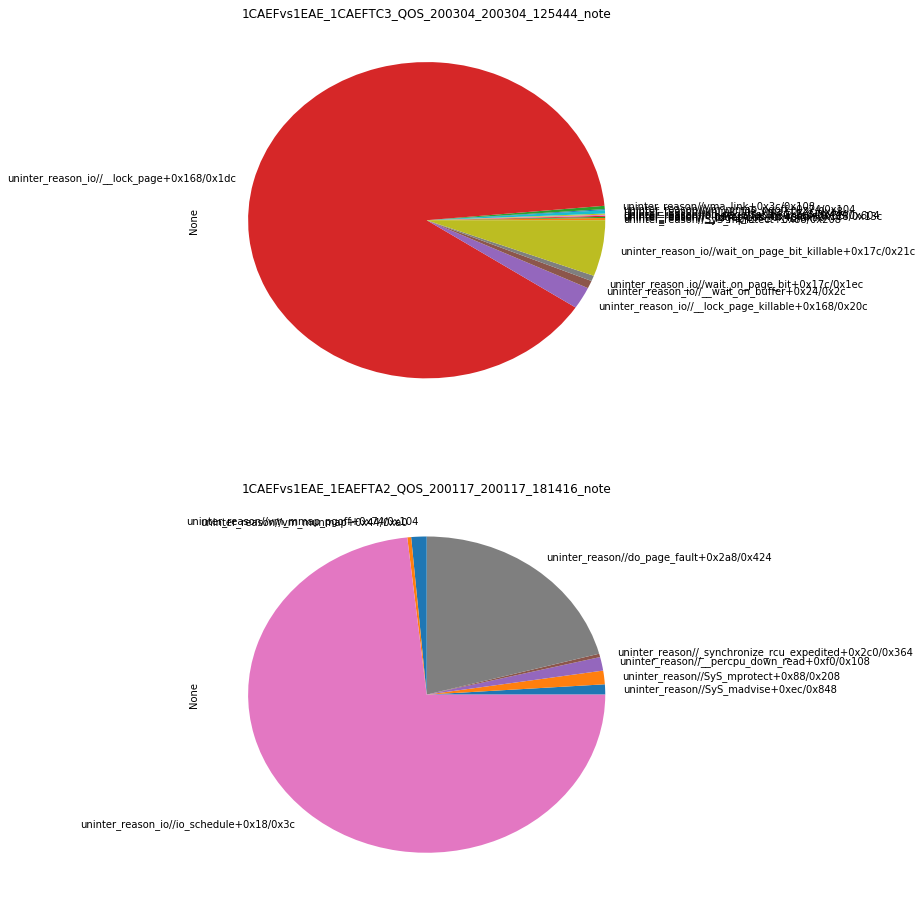

In [27]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [26]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [29]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  \
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note core0                 0   
                                                   core1                 1   
                                                   core2                 0   
                                                   core3                 3   
                                                   core4                 1   
                                                   core5                 0   
                                                   core6                37   
                                                   core7                75   
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note core0                 0   
                                                   core1                 1   
                                                   core2                 1   
                                                   core3                 2   
                                                   core4                66   
                                                   core5                22   
                                                   core6                29   
                                                   core7                34   

                                                          Choreographer #1  \
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note core0                 0   
                                                   core1                 2   
                                                   core2                 0   
                                                   core3                 0   
                                                   core4                 0   
                                                   core5                 0   
                                                   core6                17   
                                                   core7                26   
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note core0                 0   
                                                   core1                 0   
                                                   core2                 0   
                                                   core3                 0   
                                                   core4                 0   
                                                   core5                 0   
                                                   core6                 1   
                                                   core7                 2   

                                                          bindApplication  \
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note core0               10   
                                                   core1               13   
                                                   core2                7   
                                                   core3                8   
                                                   core4                2   
                                                   core5               17   
                                                   core6              310   
                                                   core7              443   
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note core0                9   
                                                   core1                6   
                                                   core2                1   
                                                   core3                2   
                                                   core4               41   
                                                   core5               64   
                                                   core6               30   
                                                   core7                7   

                                                          activityStart  \
1CAEFvs1EAE_1CAEFTC

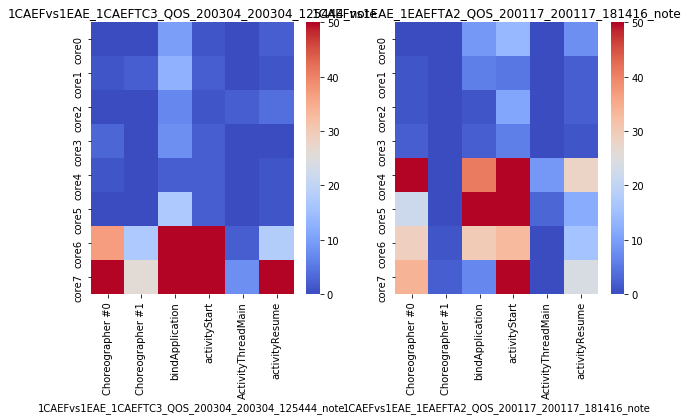

In [30]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [31]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,2,0,0,1,NaN
core1,NaN,0,2,5,0,0,0,NaN
core2,NaN,0,0,4,0,1,0,NaN
core3,NaN,1,0,4,0,0,0,NaN
core4,NaN,0,0,1,0,0,0,NaN
core5,NaN,0,0,9,0,0,0,NaN
core6,NaN,17,17,164,60,0,1,NaN
core7,NaN,18,24,177,45,3,22,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,8,0,0,1,NaN
core1,NaN,1,0,7,0,0,1,NaN
core2,NaN,0,0,2,1,1,2,NaN
core3,NaN,0,0,3,0,0,0,NaN
core4,NaN,0,0,0,0,0,0,NaN
core5,NaN,0,0,3,0,0,0,NaN
core6,NaN,6,0,106,61,0,7,NaN
core7,NaN,32,1,233,59,4,14,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,1,0,0,NaN
core1,NaN,0,0,1,2,0,0,NaN
core2,NaN,0,0,1,0,0,2,NaN
core3,NaN,2,0,1,2,0,0,NaN
core4,NaN,1,0,1,2,0,1,NaN
core5,NaN,0,0,5,2,0,1,NaN
core6,NaN,14,0,40,50,2,10,NaN
core7,NaN,25,1,33,59,1,14,NaN


In [32]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,2,6,0,3,NaN
core1,NaN,0,0,5,0,0,0,NaN
core2,NaN,0,0,1,3,0,1,NaN
core3,NaN,2,0,1,2,0,1,NaN
core4,NaN,26,0,13,13,4,10,NaN
core5,NaN,12,0,28,19,2,4,NaN
core6,NaN,4,1,1,14,0,3,NaN
core7,NaN,11,0,4,37,0,12,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,3,3,0,3,NaN
core1,NaN,1,0,1,4,0,1,NaN
core2,NaN,1,0,0,4,0,1,NaN
core3,NaN,0,0,1,2,0,0,NaN
core4,NaN,15,0,15,15,2,4,NaN
core5,NaN,7,0,11,26,1,1,NaN
core6,NaN,12,0,21,13,0,13,NaN
core7,NaN,14,1,3,28,0,5,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,4,5,0,2,NaN
core1,NaN,0,0,0,1,0,1,NaN
core2,NaN,0,0,0,4,0,0,NaN
core3,NaN,0,0,0,2,0,0,NaN
core4,NaN,25,0,13,31,3,14,NaN
core5,NaN,3,0,25,25,0,7,NaN
core6,NaN,13,0,8,6,0,0,NaN
core7,NaN,9,1,0,29,0,7,NaN


In [31]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [34]:
print(group1.title)
display(GetCoreStats(group1))

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  R  I  R  R  I  V  I         6  317.461711
                   1    I  R  R  I  R  I  V  I         6  317.462260
                   2    R  R  I  R  I  R  V  R         6  317.470903
bindApplication    0    I  R  I  I  I  R  R  V         7  317.476319
                   1    R  R  I  I  I  I  R  V         7  317.476584
                   2    R  R  I  I  I  I  R  V         7  317.477377
                   3    R  I  I  I  I  I  I  V         7  317.477718
                   4    I  I  I  I  I  I  I  V         7  317.482158
                   5    R  I  I  I  I  I  I  V         7  317.482695
                   6    I  I  I  I  I  I  I  V         7  317.484859
                   7    R  I  I  I  I  I  R  V         7  317.487403
                   8    I  I  I  I  I  I  I  V         7  317.488372
                   9    I  I  I  I  I  R  I  V         7  317.489117
                   10   I  I  I  I  I  I  I  V         7  317.491820
                   11   R  I  R  I  I  I  I  V         7  317.491926
                   12   R  R  I  I  I  R  I  V         7  317.492291
                   13   R  I  R  I  I  R  I  V         7  317.497614
                   14   R  I  I  I  I  R  I  V         7  317.497736
                   15   R  R  I  I  I  R  I  V         7  317.498181
                   16   I  I  I  R  I  I  I  V         7  317.505263
                   17   R  R  R  R  I  I  I  V         7  317.506012
                   18   I  R  R  R  I  I  I  V         7  317.506530
                   19   I  I  I  I  I  I  I  V         7  317.507300
                   20   I  I  I  I  I  V  I  I         5  317.509098
                   21   R  I  I  R  I  V  R  I         5  317.511271
                   22   I  I  I  R  I  V  R  I         5  317.512196
                   23   I  I  I  R  I  V  I  R         5  317.513916
                   24   I  I  I  R  I  V  I  I         5  317.514804
                   25   I  I  I  I  I  I  V  I         6  317.516983
                   26   I  I  I  I  I  I  V  I         6  317.520131
                   27   I  I  I  I  I  I  V  I         6  317.524683
                   28   I  I  I  I  I  I  V  I         6  317.528525
                   29   I  I  I  I  R  I  V  I         6  317.528806
                   30   R  I  I  I  I  I  V  R         6  317.529045
                   31   I  I  I  I  I  I  V  R         6  317.529957
                   32   R  R  I  I  I  I  V  I         6  317.531004
                   33   I  R  I  I  I  I  V  R         6  317.532093
                   34   I  I  I  I  I  R  V  I         6  317.533995
                   35   I  I  I  I  I  I  V  I         6  317.534400
                   36   I  I  I  I  I  I  V  I         6  317.535347
                   37   I  I  I  I  I  I  V  I         6  317.536083
                   38   I  R  I  I  I  R  V  I         6  317.537500
                   39   I  I  I  I  R  I  V  I         6  317.538079
                   40   I  I  I  I  I  I  V  I         6  317.538420
                   41   I  I  I  I  I  I  V  I         6  317.538738
                   42   I  R  I  I  I  I  V  I         6  317.539045
                   43   I  I  I  I  I  I  V  I         6  317.539431
                   44   I  I  I  I  I  I  V  I         6  317.539970
                   45   I  I  I  I  I  R  V  I         6  317.542726
                   46   R  R  R  R  I  R  V  I         6  317.545976
                   47   I  R  I  I  R  R  V  R         6  317.546715
                   48   I  I  R  I  I  I  V  R         6  317.549071
                   49   R  R  R  R  I  I  V  I         6  317.550176
                   50   I  I  I  R  I  I  V  I         6  317.550543
                   51   R  R  I  I  I  I  I  V         7  317.553571
                   52   R  R  I  R  I  I  V  I         6  317.553771
                   53   R  R  R  I  I  I  V  I         6  317.554113
                   54 

In [35]:
print(group2.title)
display(GetCoreStats(group2))

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  R  I  I  V  I  I  I         4  325.335638
                   1    I  R  I  I  V  I  I  I         4  325.336309
                   2    I  I  R  I  R  I  V  I         6  325.344881
bindApplication    0    V  R  R  I  I  I  I  I         0  325.346336
                   1    R  I  R  I  I  V  I  I         5  325.346427
                   2    I  I  R  I  R  V  I  I         5  325.346658
                   3    I  I  R  I  R  V  I  I         5  325.347377
                   4    I  I  R  I  R  V  I  I         5  325.347608
                   5    I  I  R  I  R  V  I  I         5  325.352723
                   6    I  I  R  I  R  V  I  I         5  325.354391
                   7    I  I  R  I  R  V  I  I         5  325.356048
                   8    I  I  I  I  I  V  I  I         5  325.361504
                   9    I  I  R  I  R  V  I  I         5  325.374149
                   10   I  I  R  I  R  V  I  I         5  325.374180
                   11   I  I  R  I  R  V  R  I         5  325.374207
                   12   I  I  I  I  R  V  R  I         5  325.378417
                   13   I  I  I  I  R  V  R  I         5  325.381412
                   14   R  I  I  I  R  V  R  I         5  325.381722
                   15   I  I  I  I  R  V  R  I         5  325.382118
                   16   I  I  I  I  R  V  I  I         5  325.382817
                   17   V  I  R  I  R  R  R  I         0  325.387920
                   18   I  R  R  I  R  R  V  I         6  325.387977
                   19   R  R  R  I  V  I  R  I         4  325.389374
                   20   I  I  I  I  V  R  R  I         4  325.393191
                   21   R  R  I  I  V  R  R  I         4  325.394477
                   22   I  I  I  I  V  R  R  I         4  325.395442
                   23   R  I  I  I  R  V  I  I         5  325.395830
                   24   I  I  I  I  V  R  R  I         4  325.396396
                   25   R  I  R  I  R  V  I  I         5  325.398220
                   26   I  I  I  I  R  V  R  I         5  325.398718
                   27   I  I  I  I  R  V  I  I         5  325.400318
                   28   I  I  I  I  R  V  I  I         5  325.400445
                   29   I  R  I  I  R  V  I  I         5  325.400536
                   30   V  I  R  I  I  R  R  R         0  325.401428
                   31   V  I  I  I  R  I  I  R         0  325.403865
                   32   I  R  R  R  V  I  R  R         4  325.406331
                   33   I  R  I  I  V  I  I  I         4  325.414494
                   34   I  R  I  I  R  I  V  I         6  325.415903
                   35   I  R  I  R  I  R  V  I         6  325.416637
                   36   I  R  I  I  R  V  R  R         5  325.417496
                   37   I  I  R  I  R  V  I  R         5  325.417652
                   38   I  I  I  R  R  V  R  R         5  325.418333
                   39   I  R  I  I  V  R  I  R         4  325.419188
                   40   I  I  I  R  V  I  I  R         4  325.420188
                   41   I  I  I  I  V  I  I  R         4  325.420795
                   42   I  R  I  I  V  I  I  R         4  325.426473
                   43   I  I  I  I  R  R  V  R         6  325.428173
                   44   R  I  I  I  R  R  V  I         6  325.434059
                   45   R  I  I  R  I  R  V  I         6  325.439703
                   46   R  R  R  R  R  I  V  R         6  325.444678
                   47   I  R  R  I  V  I  I  R         4  325.445046
                   48   I  R  R  I  V  R  R  R         4  325.452149
                   49   R  R  I  R  I  R  V  R         6  325.455565
activityStart      0    R  I  R  R  I  R  V  R         6  325.456578
                   1    I  I  I  R  I  I  I  V         7  325.458660
                   2    I  I  I  I  R  R  I  V         7  325.463383
                   3    R  R  I  R  V  R  I  I         4  325.464332
                   4  

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [34]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


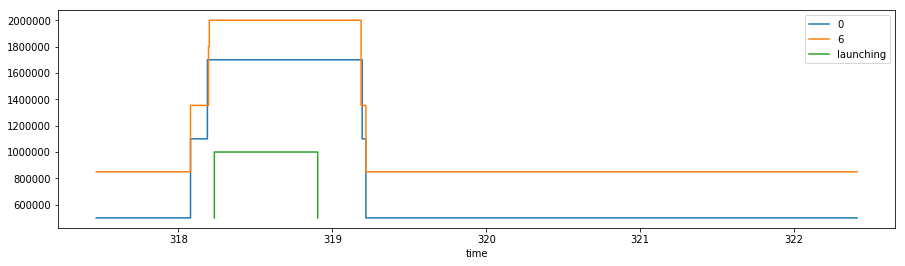

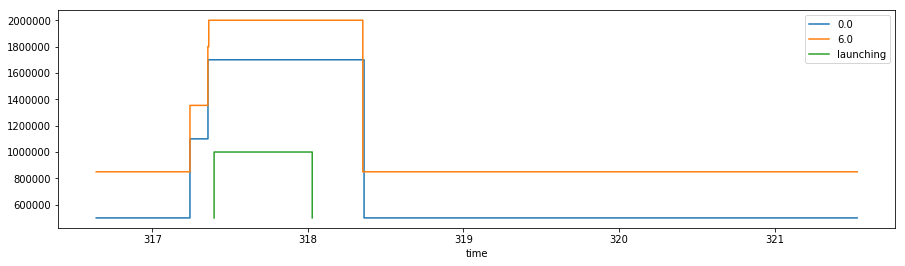

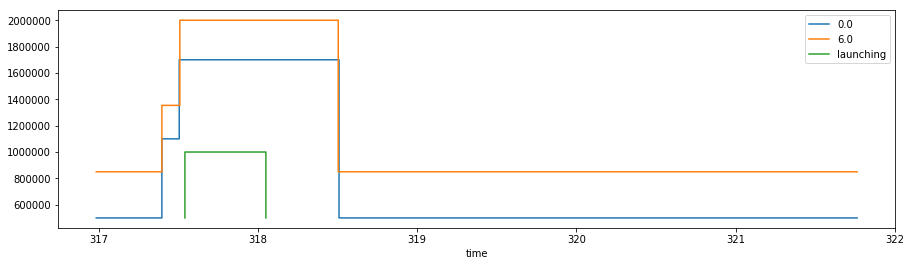

In [37]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']


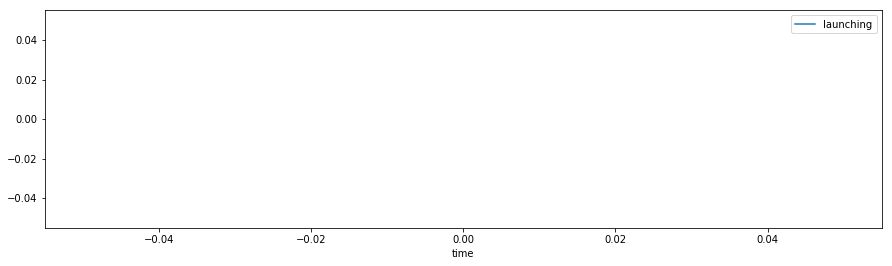

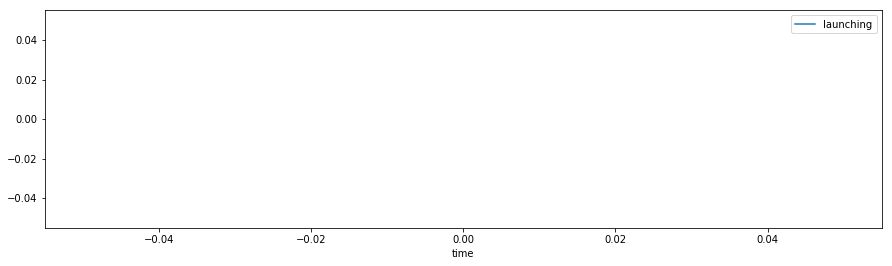

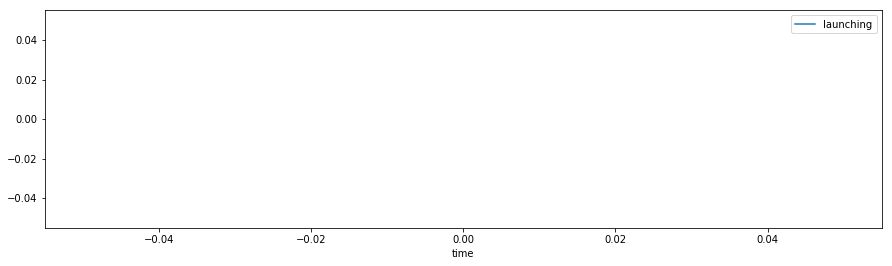

In [38]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [37]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


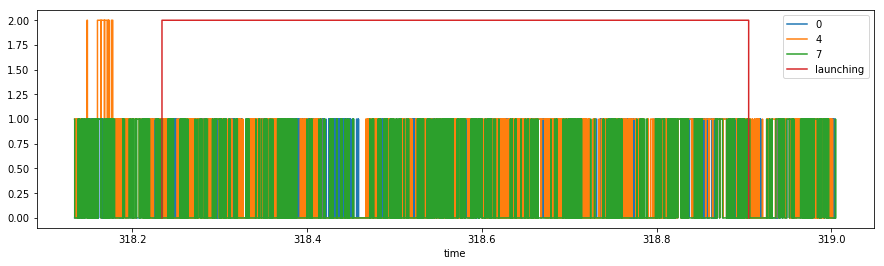

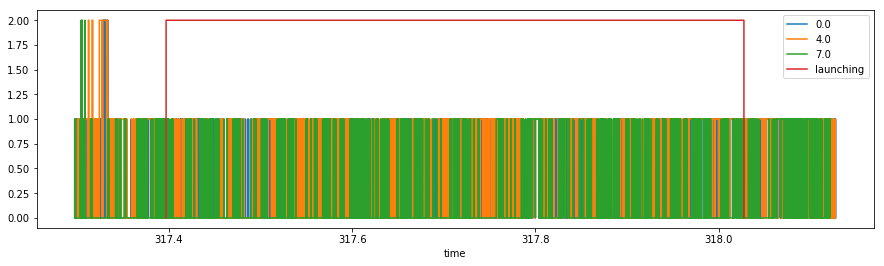

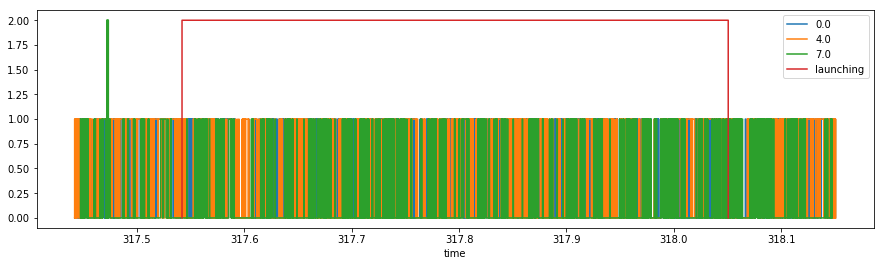

In [40]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

14IGZUQ_nytimes


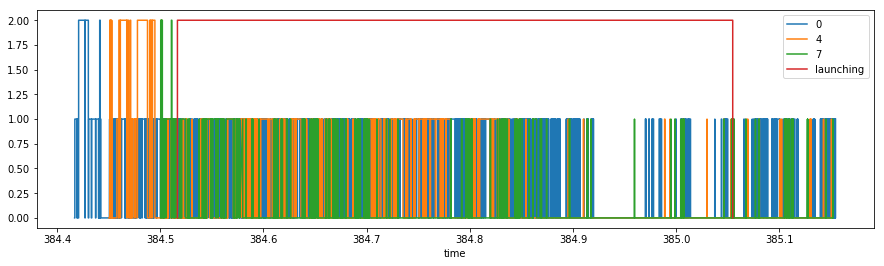

In [41]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [40]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [43]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
14IGZUP_nytimes,lock_contention,0,0.000,0,9.902,0.000,0,6.380,0
14IGZUQ_nytimes,lock_contention,0,9.212,0,0.000,4.168,0,21.552,0
DIFF,lock_contention,0,-9.212,0,9.902,-4.168,0,-15.172,0


In [42]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [45]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'14IGZUP_nytimes'

,blocking,context,duration,effection,owner,pid,time,type
101,java.lang.String com.tune.TuneParameters.getS...,monitor contention with owner main (14286) at ...,5.781,O,main (14286) at boolean android.os.BinderProxy...,14343,796.516779,B
134,"byte[] iv.a(byte[], java.lang.String)(:com.go...",monitor contention with owner gads-4 (14411) a...,5.198,O,"gads-4 (14411) at byte[] iv.a(byte[], java.lan...",14409,796.751908,B
90,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1310_8 (2...,4.125,O,Binder:1310_8 (2085) at int com.android.server...,3889,796.473521,B
92,void com.android.server.am.ActivityManagerSer...,monitor contention with owner Binder:1310_8 (2...,3.454,O,Binder:1310_8 (2085) at int com.android.server...,1418,796.476401,B
39,boolean com.android.server.wm.WindowManagerSe...,monitor contention with owner android.anim (16...,3.370,O,android.anim (1608) at int com.android.server....,2220,796.430818,B
172,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,2.848,O,android.anim (1608) at void com.android.server...,1428,796.799537,B
40,void com.android.server.wm.WindowManagerServi...,monitor contention with owner android.anim (16...,2.655,O,android.anim (1608) at int com.android.server....,1428,796.431600,B
80,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:1310_E (2...,2.498,O,Binder:1310_E (2220) at android.app.ActivityMa...,2085,796.457363,B
79,void com.android.server.wm.StackWindowControl...,monitor contention with owner android.anim (16...,2.483,O,android.anim (1608) at void com.android.server...,2220,796.457227,B
58,java.util.List com.android.server.am.Activity...,monitor contention with owner Binder:1310_19 (...,2.404,O,Binder:1310_19 (3889) at int com.android.serve...,6320,796.445466,B


In [46]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'14IGZUQ_nytimes'

,blocking,context,duration,effection,owner,pid,time,type
167,int com.android.server.wm.WindowManagerServic...,monitor contention with owner android.anim (14...,7.728,O,android.anim (1430) at void com.android.server...,3268,384.924388,B
170,java.util.TimeZone java.util.TimeZone.getTime...,monitor contention with owner Picasso-/mobile/...,7.501,O,Picasso-/mobile/android/v1/icons/hdpi/theater....,16307,384.927215,B
169,int com.android.server.wm.WindowManagerServic...,monitor contention with owner android.anim (14...,7.362,O,android.anim (1430) at void com.android.server...,3363,384.926471,B
168,void com.android.server.wm.ActivityServiceCon...,monitor contention with owner android.anim (14...,6.853,O,android.anim (1430) at void com.android.server...,2155,384.925672,B
44,boolean com.android.server.wm.ActivityTaskMan...,monitor contention with owner Binder:1252_A (2...,5.563,O,Binder:1252_A (2155) at java.util.List com.and...,4129,384.549323,B
11,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1252_14 (...,4.779,O,Binder:1252_14 (3268) at void com.android.serv...,1985,384.519879,B
194,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1252_A (2...,4.142,O,Binder:1252_A (2155) at int com.android.server...,1426,384.964229,B
130,android.content.pm.PackageInfo com.android.se...,monitor contention with owner Binder:1252_A (2...,3.609,O,Binder:1252_A (2155) at java.util.List com.and...,2151,384.861214,B
516,"bfs$a bfs.q(java.lang.String, long)(SourceFil...",monitor contention with owner RxIoScheduler-7 ...,2.828,O,RxIoScheduler-7 (16428) at void bfs$a.commit()...,16415,385.523229,B
184,int com.android.server.wm.ActivityTaskManager...,monitor contention with owner android.anim (14...,2.669,O,android.anim (1430) at void com.android.server...,2155,384.940494,B


In [47]:
display(group1.title)
display(df1['duration'].sum())

u'14IGZUP_nytimes'

88.51399999957721

In [48]:
display(group2.title)
display(df2['duration'].sum())

u'14IGZUQ_nytimes'

151.33200000025226

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [49]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'14IGZUP_nytimes'

,owner
"gads-6 (14416) at byte[] iv.a(byte[], java.lang.String)(:com.google.android.gms.policy_ads_fdr_dynamite@20461000@20461000.264725060.264725060:18)",6
"Binder:1310_8 (2085) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:544)",5
"gads-4 (14411) at byte[] iv.a(byte[], java.lang.String)(:com.google.android.gms.policy_ads_fdr_dynamite@20461000@20461000.264725060.264725060:18)",5
ActivityManager (1417) at void com.android.server.am.BroadcastQueue.processNextBroadcast(boolean)(BroadcastQueue.java:1113),5
"gads-2 (14406) at byte[] iv.a(byte[], java.lang.String)(:com.google.android.gms.policy_ads_fdr_dynamite@20461000@20461000.264725060.264725060:18)",4
"Binder:1310_8 (2085) at int com.android.server.am.ActivityManagerService.bindService(android.app.IApplicationThread, android.os.IBinder, android.content.Intent, java.lang.String, android.app.IServiceConnection, int, java.lang.String, int)(ActivityManagerService.java:25397)",4
"Binder:1310_19 (3889) at android.content.pm.PackageInfo com.android.server.pm.PackageManagerService.getPackageInfoInternal(java.lang.String, long, int, int, int)(PackageManagerService.java:5065)",3
AdWorker(Default) #1 (14397) at void java.lang.Thread.unpark$()(Thread.java:2079),3
"Binder:1310_E (2220) at void com.android.server.am.ActivityManagerService.publishService(android.os.IBinder, android.content.Intent, android.os.IBinder)(ActivityManagerService.java:25415)",3
android.anim (1608) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:153),3


In [50]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'14IGZUQ_nytimes'

,owner
gads-3 (16288) at int sun.security.jca.ProviderList.loadAll()(ProviderList.java:273),9
android.anim (1430) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),8
gads-8 (16294) at java.lang.Object java.lang.Throwable.nativeFillInStackTrace()(Throwable.java:-2),7
"Binder:1252_4 (1985) at java.util.List com.android.server.pm.PackageManagerService.queryIntentActivitiesInternal(android.content.Intent, java.lang.String, int, int, int, boolean, boolean)(PackageManagerService.java:8656)",4
"android.anim (1430) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2246)",4
"Binder:1252_14 (3268) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2246)",4
"gads-11 (16297) at byte[] eb.a(byte[], java.lang.String)(:com.google.android.gms.policy_ads_fdr_dynamite@21001000@21001000.272763194.272763194:20)",3
"Binder:1252_15 (3363) at java.util.List com.android.server.wm.ActivityTaskManagerService.getFilteredTasks(int, int, int)(ActivityTaskManagerService.java:3303)",3
"Binder:1252_4 (1985) at android.content.pm.PackageInfo com.android.server.pm.PackageManagerService.getPackageInfoInternal(java.lang.String, long, int, int, int)(PackageManagerService.java:5192)",3
"gads-14 (16301) at byte[] eb.a(byte[], java.lang.String)(:com.google.android.gms.policy_ads_fdr_dynamite@21001000@21001000.272763194.272763194:20)",3


Text(0,0.5,'weight')

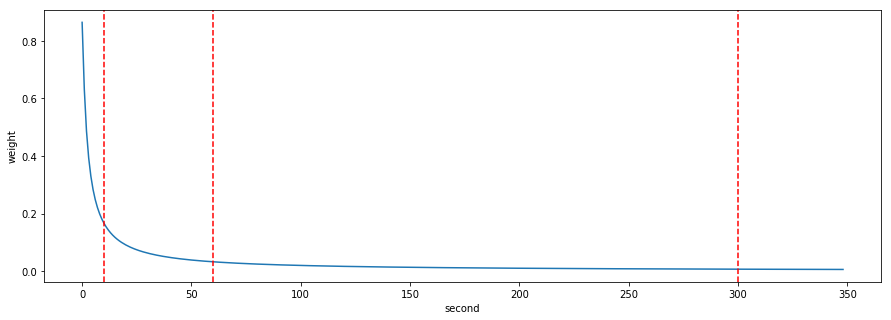

In [49]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')